# Clasificación de textos cortos en emociones

## Contexto:
El análisis de sentimientos es un área que genera valor en múltiples industrias. Usualmente se utilizan técnicas de NLP para clasificar rápidamente textos en un sentimiento positivo, negativo o neutral. Sin embargo, esta clasificación es bastante limitada y no permite un entendimiento profundo. Por esto, se requiere clasificar textos cortos en un espectro de emociones.

Para este caso se abordan las emociones desde un punto de vista clásico en el cual se clasifican en 7 emociones principales: 
1) `shame` = vergüenza
2) `sadness` = tristeza
3) `joy` = alegría
4) `guilt` = culpa
5) `fear` = miedo
6) `disgust` = asco
7) `anger` = ira

Se utiliza el conjunto de datos **ISEAR**, que consiste de 7666 encuestas realizadas por múltiples psicológos en los años 90 en varios países. La encuesta consistía en presentarle una emoción al entrevistado y este debía responder una situación que representara dicha emoción. Este dataset fue elegido porque ha sido ampliamente utilizado para entrenar y comparar el rendimiento de modelos en la detección de emociones.

## Objetivo:
El objetivo de este Notebook es evaluar el rendimiento de diferentes modelos para la clasificación del texto en emociones.

## Procedimiento:
Se van a evaluar el rendimiento de modelos correspondientes a diferentes técnicas: técnicas de **machine learning**, técnicas de **redes neuronales** y **transformers**

## 0. Libraries and input data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
df = pd.read_parquet("../data/cleaned/isear_cleaned.parquet")
df.head(3)

,text,emotion
0,when a boy tried to fool me so he would be ok ...,anger
1,i felt anger when i saw that i was being misle...,anger
2,once a friend had pushed me and i had fallen o...,anger


# 2. Técnicas de Redes Neuronales

Se van a utilizar `Redes Neuronales Convolucionales (CNNs)`, `Redes Neuronales Recurrentes (RNNs)` y `Long Short-Term Memory (LSTM)` para realizar un proceso de clasificación multiclase.

## 2.1.1. CNN con One-Hot Encoding

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Suponiendo que tu DataFrame se llama 'df' y tiene las columnas 'text' y 'emotion'
texts = df["text"].values  # Extraer la columna de texto
emotions = df["emotion"].values  # Extraer la columna de emociones

# Mapeamos las emociones a etiquetas numéricas (puedes ajustar esto según tu DataFrame)
emotion_labels = {
    "shame": 0,
    "sadness": 1,
    "joy": 2,
    "anger": 3,
    "fear": 4,
    "guilt": 5,
    "disgust": 6,
}

# Convertir las emociones en etiquetas numéricas
labels = [emotion_labels[emotion] for emotion in emotions]

# Parámetros
vocab_size = 1000  # Tamaño máximo del vocabulario
max_len = 100  # Longitud máxima de las secuencias (ajusta según tu caso)
num_classes = 7  # Número de clases (emociones)

# Tokenización y codificación One-Hot
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Rellenar secuencias a una longitud fija (max_len)
data = pad_sequences(sequences, maxlen=max_len)

# Convertir etiquetas a formato categórico (One-Hot)
labels = to_categorical(np.asarray(labels), num_classes=num_classes)

# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Dense,
    Embedding,
    GlobalMaxPooling1D,
)

# Definir el modelo CNN
model = Sequential()

# Capa de Embedding para representar la codificación One-Hot
model.add(Embedding(input_dim=vocab_size, output_dim=128))

# Capa Convolucional con 128 filtros y un tamaño de filtro de 5
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))

# Capa de Pooling Global para reducir la dimensionalidad
model.add(GlobalMaxPooling1D())

# Capa densa para clasificación
model.add(Dense(64, activation="relu"))

# Capa de salida para clasificación multiclase (7 clases)
model.add(Dense(num_classes, activation="softmax"))  # 7 clases, activación softmax

# Compilar el modelo con la pérdida 'categorical_crossentropy' y métrica 'accuracy'
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Mostrar la arquitectura del modelo
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Definir el callback EarlyStopping para detener el entrenamiento si no mejora después de 3 épocas
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo con el callback de EarlyStopping
history = model.fit(
    X_train,
    y_train,
    epochs=10,  # Aumentamos el número de épocas
    batch_size=32,
    validation_data=(X_val, y_val),
    # callbacks=[early_stopping]  # Añadir el callback
)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9901 - loss: 0.0233 - val_accuracy: 0.5046 - val_loss: 5.0182
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9889 - loss: 0.0251 - val_accuracy: 0.5206 - val_loss: 5.0091
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9887 - loss: 0.0248 - val_accuracy: 0.5060 - val_loss: 4.9378
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9887 - loss: 0.0258 - val_accuracy: 0.5033 - val_loss: 5.1587
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9882 - loss: 0.0251 - val_accuracy: 0.5153 - val_loss: 5.0024
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9904 - loss: 0.0215 - val_accuracy: 0.5046 - val_loss: 4.9749
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9879 - loss: 0.0237 - val_accuracy: 0.5166 - val_loss: 5.0537
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9838 - loss: 0.0457 - val_accu

In [38]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4634 - loss: 5.0232
Test accuracy: 0.44429707527160645


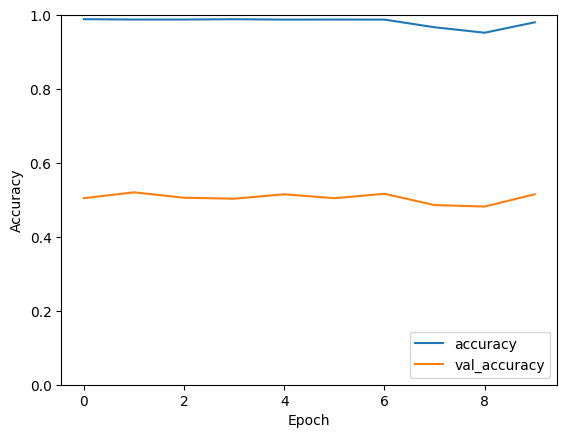

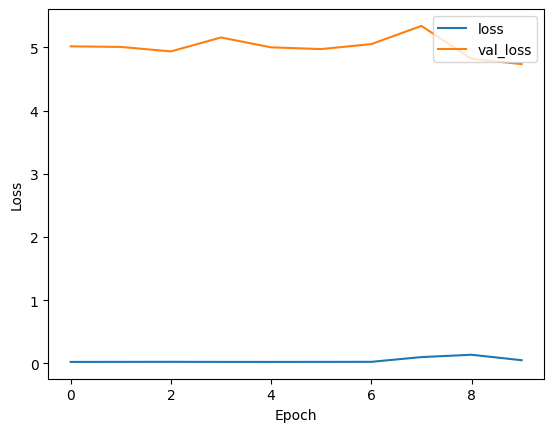

In [39]:
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

# Graficar pérdida
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


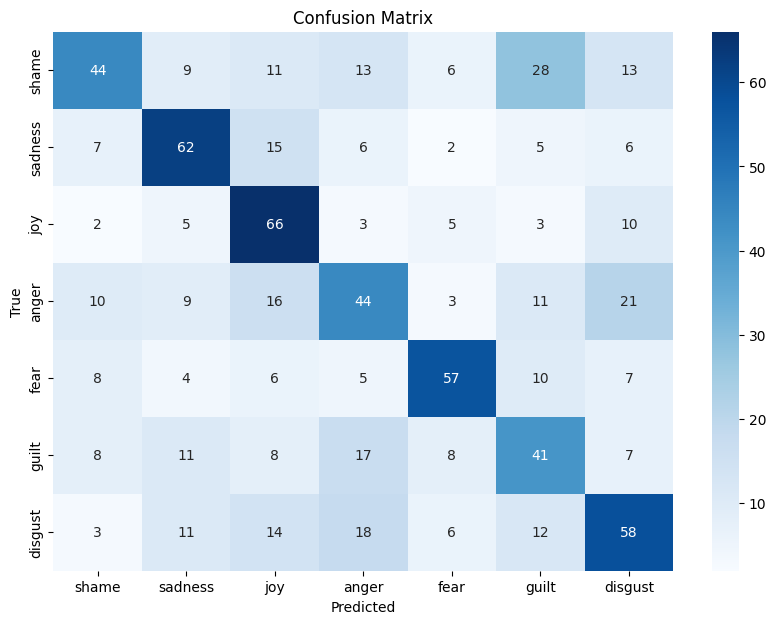

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Hacer predicciones en el conjunto de prueba
y_test_pred_cnn = model.predict(X_test)

# Convertir las predicciones de probabilidades a etiquetas
y_test_pred_classes_cnn = np.argmax(y_test_pred_cnn, axis=1)

# Convertir las etiquetas verdaderas a clases
y_test_true_classes_cnn = np.argmax(y_test, axis=1)

# Calcular el reporte de clasificación
cnn_report = classification_report(
    y_test_true_classes_cnn, y_test_pred_classes_cnn, output_dict=True
)

# Extraer las métricas globales del reporte
cnn_accuracy = accuracy_score(y_test_true_classes_cnn, y_test_pred_classes_cnn)
cnn_precision = cnn_report["macro avg"]["precision"]
cnn_recall = cnn_report["macro avg"]["recall"]
cnn_f1_score = cnn_report["macro avg"]["f1-score"]


import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Etiquetas de las emociones para visualizar en la matriz
emotion_labels = ["shame", "sadness", "joy", "anger", "fear", "guilt", "disgust"]

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [41]:
# Calcular las métricas globales
report = classification_report(
    y_test_true_classes, y_test_pred_classes, target_names=emotion_labels
)

# Imprimir el reporte
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       shame       0.54      0.35      0.43       124
     sadness       0.56      0.60      0.58       103
         joy       0.49      0.70      0.57        94
       anger       0.42      0.39      0.40       114
        fear       0.66      0.59      0.62        97
       guilt       0.37      0.41      0.39       100
     disgust       0.48      0.48      0.48       122

    accuracy                           0.49       754
   macro avg       0.50      0.50      0.50       754
weighted avg       0.50      0.49      0.49       754



In [42]:
from sklearn.metrics import accuracy_score

# Calcular la precisión global
accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print(f"Global Accuracy: {accuracy}")

Global Accuracy: 0.493368700265252


In [43]:
df_metrics_test = pd.read_excel("../data/model_results/ml_models.xlsx")
df_metrics_test

,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."
1,Decision Tree,0.456233,0.462894,0.455871,0.457728,"{'classifier__class_weight': 'balanced', 'clas..."
2,Random Forest,0.579576,0.578603,0.578619,0.576472,"{'classifier__criterion': 'gini', 'classifier_..."


In [44]:
# Crear un diccionario con las métricas del modelo CNN
cnn_metrics_data = {
    "Model": "CNN",
    "Test Macro Accuracy": cnn_accuracy,
    "Test Macro Precision": cnn_precision,
    "Test Macro Recall": cnn_recall,
    "Test Macro F1-Score": cnn_f1_score,
    "Best Parameters": "N/A",  # No usamos GridSearchCV, así que no hay parámetros ajustados
}

# Convertir los resultados en un DataFrame
df_cnn_metrics = pd.DataFrame([cnn_metrics_data])

# Agregar los resultados de CNN al DataFrame existente
df_metrics_test = pd.concat([df_metrics_test, df_cnn_metrics], ignore_index=True)

# Mostrar el DataFrame actualizado
display(df_metrics_test)

,Model,Test Macro Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVM,0.580902,0.587406,0.580054,0.582579,"{'classifier__C': 10, 'classifier__class_weigh..."
1,Decision Tree,0.456233,0.462894,0.455871,0.457728,"{'classifier__class_weight': 'balanced', 'clas..."
2,Random Forest,0.579576,0.578603,0.578619,0.576472,"{'classifier__criterion': 'gini', 'classifier_..."
3,CNN,0.444297,0.451037,0.450461,0.449188,N/A


## CNN con word2vec emmbeding

In [46]:
import gensim.downloader as api

# Cargar el modelo preentrenado de Word2Vec (puedes cambiar a otro modelo si lo prefieres)
word2vec_model = api.load(
    "word2vec-google-news-300"
)  # Word2Vec entrenado en Google News (300 dimensiones)


In [47]:
import gensim.downloader as api

# Cargar el modelo preentrenado de GloVe (puedes cambiar el tamaño si lo prefieres)
glove_model = api.load(
    "glove-wiki-gigaword-100"
)  # GloVe preentrenado (100 dimensiones)


In [48]:
import numpy as np


# Función para crear la matriz de embeddings usando un modelo preentrenado (Word2Vec o GloVe)
def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_vector = embedding_model[word]
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_dim_w2v = (
    300  # Dimensión de Word2Vec (puedes ajustarla según el modelo cargado)
)
embedding_matrix_w2v = create_embedding_matrix(
    tokenizer.word_index, word2vec_model, embedding_dim_w2v
)

embedding_dim_glove = (
    100  # Dimensión de GloVe (puedes ajustarla según el modelo cargado)
)
embedding_matrix_glove = create_embedding_matrix(
    tokenizer.word_index, glove_model, embedding_dim_glove
)


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Dense,
    Embedding,
    GlobalMaxPooling1D,
    Dropout,
)

# Definir el modelo CNN usando embeddings de Word2Vec
model_w2v = Sequential()

# Capa de Embedding con pesos preentrenados de Word2Vec
model_w2v.add(
    Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=embedding_dim_w2v,
        weights=[embedding_matrix_w2v],
        trainable=False,
    )
)  # Los embeddings no se entrenarán

# Capa Convolucional
model_w2v.add(Conv1D(128, 5, activation="relu"))
model_w2v.add(MaxPooling1D(5))

# Capa Convolucional adicional
model_w2v.add(Conv1D(128, 5, activation="relu"))
model_w2v.add(MaxPooling1D(5))

# Pooling Global
model_w2v.add(GlobalMaxPooling1D())

# Capa Densa y Dropout para regularización
model_w2v.add(Dense(128, activation="relu"))
model_w2v.add(Dropout(0.5))

# Capa de salida para clasificación multiclase
model_w2v.add(Dense(num_classes, activation="softmax"))

# Compilar el modelo
model_w2v.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Mostrar la arquitectura del modelo
model_w2v.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     2,731,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,731,800 (10.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,731,800 (10.42 MB)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback EarlyStopping para detener el entrenamiento si no mejora después de 3 épocas
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Entrenar el modelo (usa el modelo con Word2Vec o GloVe)
history_w2v = model_w2v.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

# O puedes entrenar el modelo con GloVe:
#


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1828 - loss: 1.9300 - val_accuracy: 0.3533 - val_loss: 1.6779
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4144 - loss: 1.5367 - val_accuracy: 0.5073 - val_loss: 1.3251
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5758 - loss: 1.1791 - val_accuracy: 0.5299 - val_loss: 1.2939
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6697 - loss: 0.9419 - val_accuracy: 0.5352 - val_loss: 1.3122
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7419 - loss: 0.7329 - val_accuracy: 0.5232 - val_loss: 1.4338
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8153 - loss: 0.5462 - val_accuracy: 0.5033 - val_loss: 1.7802
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8600 - loss: 0.4170 - val_accuracy: 0.4834 - val_loss: 1.8529
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8962 - loss: 0.3070 - val_accu

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


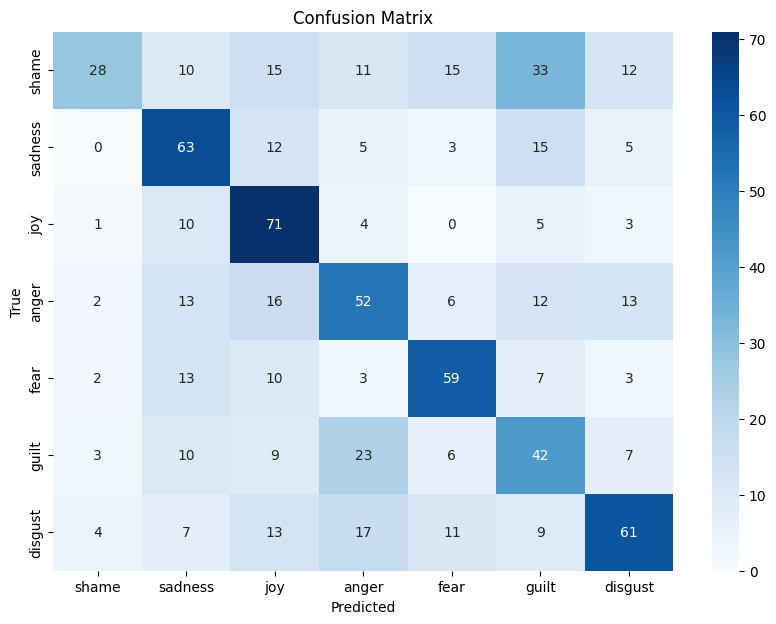

Classification Report:
              precision    recall  f1-score   support

       shame       0.70      0.23      0.34       124
     sadness       0.50      0.61      0.55       103
         joy       0.49      0.76      0.59        94
       anger       0.45      0.46      0.45       114
        fear       0.59      0.61      0.60        97
       guilt       0.34      0.42      0.38       100
     disgust       0.59      0.50      0.54       122

    accuracy                           0.50       754
   macro avg       0.52      0.51      0.49       754
weighted avg       0.53      0.50      0.49       754

Global Accuracy: 0.4986737400530504


In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Hacer predicciones en el conjunto de prueba
y_test_pred = model_w2v.predict(X_test)  # Cambia a model_glove si usas GloVe

# Convertir las predicciones de probabilidades a etiquetas
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convertir las etiquetas verdaderas a clases
y_test_true_classes = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calcular el reporte de clasificación para el modelo
report = classification_report(
    y_test_true_classes, y_test_pred_classes, target_names=emotion_labels
)
print("Classification Report:")
print(report)

# Calcular la precisión global
accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print(f"Global Accuracy: {accuracy}")


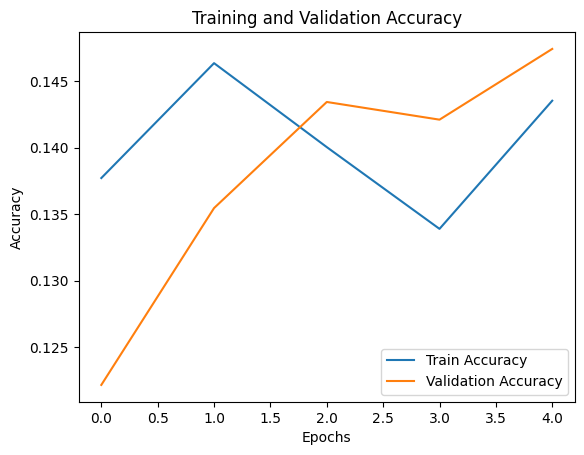

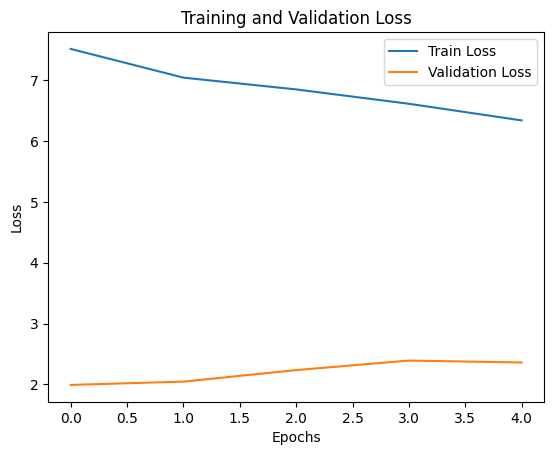

In [65]:
# Graficar la precisión durante el entrenamiento y la validación
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Graficar la pérdida durante el entrenamiento y la validación
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


GloVe

In [67]:
# Definir el modelo CNN usando embeddings de GloVe
model_glove = Sequential()

# Capa de Embedding con pesos preentrenados de GloVe
model_glove.add(
    Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=embedding_dim_glove,
        weights=[embedding_matrix_glove],
        trainable=False,
    )
)  # Los embeddings no se entrenarán

# Capa Convolucional
model_glove.add(Conv1D(128, 5, activation="relu"))
model_glove.add(MaxPooling1D(5))

# Capa Convolucional adicional
model_glove.add(Conv1D(128, 5, activation="relu"))
model_glove.add(MaxPooling1D(5))

# Pooling Global
model_glove.add(GlobalMaxPooling1D())

# Capa Densa y Dropout para regularización
model_glove.add(Dense(128, activation="relu"))
model_glove.add(Dropout(0.5))

# Capa de salida para clasificación multiclase
model_glove.add(Dense(num_classes, activation="softmax"))

# Compilar el modelo
model_glove.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Mostrar la arquitectura del modelo
model_glove.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │       910,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 910,600 (3.47 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 910,600 (3.47 MB)

In [72]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True
)


In [73]:
history_glove = model_glove.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8764 - loss: 0.3698 - val_accuracy: 0.4874 - val_loss: 2.0895
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9187 - loss: 0.2487 - val_accuracy: 0.4900 - val_loss: 2.2150
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9153 - loss: 0.2657 - val_accuracy: 0.4622 - val_loss: 2.3112
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9240 - loss: 0.2353 - val_accuracy: 0.4515 - val_loss: 2.4893
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9322 - loss: 0.2075 - val_accuracy: 0.4728 - val_loss: 2.6279
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9317 - loss: 0.2039 - val_accuracy: 0.4502 - val_loss: 2.7885
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9386 - loss: 0.1836 - val_accuracy: 0.4675 - val_loss: 2.8900
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9257 - loss: 0.2176 - val_accur

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


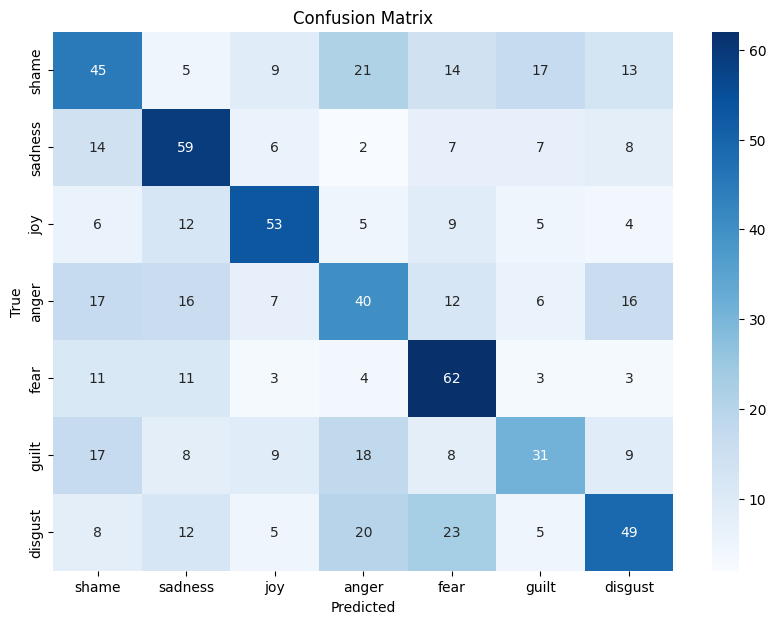

Classification Report:
              precision    recall  f1-score   support

       shame       0.38      0.36      0.37       124
     sadness       0.48      0.57      0.52       103
         joy       0.58      0.56      0.57        94
       anger       0.36      0.35      0.36       114
        fear       0.46      0.64      0.53        97
       guilt       0.42      0.31      0.36       100
     disgust       0.48      0.40      0.44       122

    accuracy                           0.45       754
   macro avg       0.45      0.46      0.45       754
weighted avg       0.45      0.45      0.44       754

Global Accuracy: 0.4496021220159151


In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# Hacer predicciones en el conjunto de prueba
y_test_pred = model_glove.predict(X_test)  # Cambia a model_glove si usas GloVe

# Convertir las predicciones de probabilidades a etiquetas
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convertir las etiquetas verdaderas a clases
y_test_true_classes = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calcular el reporte de clasificación para el modelo
report = classification_report(
    y_test_true_classes, y_test_pred_classes, target_names=emotion_labels
)
print("Classification Report:")
print(report)

# Calcular la precisión global
accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print(f"Global Accuracy: {accuracy}")


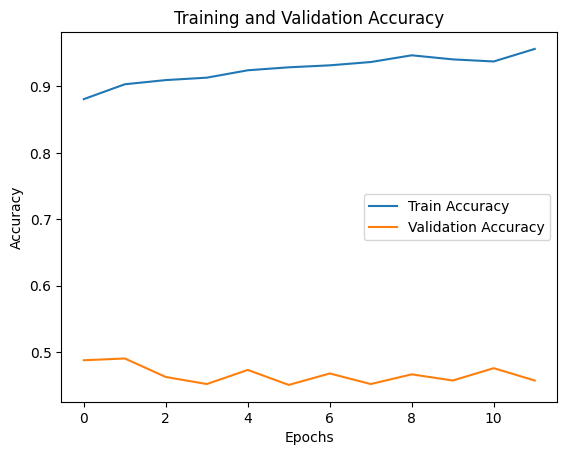

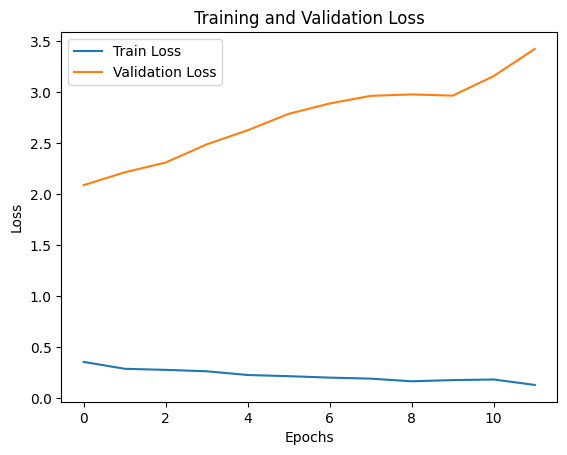

In [76]:
# Graficar la precisión durante el entrenamiento y la validación
plt.plot(history_glove.history["accuracy"], label="Train Accuracy")
plt.plot(history_glove.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Graficar la pérdida durante el entrenamiento y la validación
plt.plot(history_glove.history["loss"], label="Train Loss")
plt.plot(history_glove.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()